# Noise detecting

#### Important: This is a trial for better model performance, while the time don't allow us to further developing. For this edition of noise detecting, the effect is not good as expected. We will not use this in our project before transaction preprocessing. 

#### However, with the help of this brave trial, we still dig deeper into the raw dataset, which of course help us improve our implementation in our formal work :)

About 10% noise is hiding in raw transaction dataset. Clustering method would be conducted to try to find out the noise.

In [1]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [64]:
transaction = pd.read_parquet('../data/curated/transaction/transaction_merged.parquet')

# reset index
transaction = transaction.reset_index(drop=True)
transaction

,user_id,merchant_abn,dollar_value,order_id,order_datetime
0,1,28000487688,133.226894,0c37b3f7-c7f1-48cb-bcc7-0a58e76608ea,2021-02-28
1,18485,62191208634,79.131400,9e18b913-0465-4fd4-92fd-66d15e65d93c,2021-02-28
2,1,83690644458,30.441348,40a2ff69-ea34-4657-8429-df7ca957d6a1,2021-02-28
3,18488,39649557865,962.813341,f4c1a5ae-5b76-40d0-ae0f-cb9730ac325a,2021-02-28
4,2,80779820715,48.123977,cd09bdd6-f56d-489f-81ea-440f4bda933c,2021-02-28
...,...,...,...,...,...
14195500,11136,77698107389,400.792069,5e68cb94-3eab-4342-83fa-65263eff26b8,2022-10-26
14195501,11136,24852446429,5.384811,ba2ce936-ae49-4b70-a4b1-e8f8bacaefb3,2022-10-26
14195502,11136,63685007785,48.129887,a6194c61-ae7a-4037-a425-2dd7cda42fb7,2022-10-26
14195503,11137,85502310765,4.768752,72a3639e-25d5-4bcc-9e8b-26e737b8c0e4,2022-10-26


check if there is any not unique order

In [ ]:
# check how many not unique order_id
transaction['order_id'].nunique()

great to see that :) so just drop order_id is fine

In [3]:
transaction.drop(["order_id"], axis=1, inplace=True)
transaction.describe()

,user_id,merchant_abn,dollar_value
count,1.419550e+07,1.419550e+07,1.419550e+07
mean,1.204044e+04,5.542436e+10,1.662290e+02
std,6.951450e+03,2.532810e+10,5.178506e+02
min,1.000000e+00,1.002328e+10,9.756658e-08
25%,6.020000e+03,3.284414e+10,2.612958e+01
50%,1.204100e+04,5.528299e+10,6.223040e+01
75%,1.806000e+04,7.733862e+10,1.504517e+02
max,2.408100e+04,9.999054e+10,1.051939e+05


In [13]:
# get 0.01 of the data
transaction_sample = transaction.sample(frac=0.1, random_state=42)

# date processing
transaction_sample['order_datetime'] = pd.to_datetime(transaction_sample['order_datetime'])
transaction_sample['order_year'] = transaction_sample['order_datetime'].dt.year
transaction_sample['order_month'] = transaction_sample['order_datetime'].dt.month
transaction_sample['order_day'] = transaction_sample['order_datetime'].dt.day
transaction_sample.drop(['order_datetime'], axis=1, inplace=True)

transaction_sample

,user_id,merchant_abn,dollar_value,order_year,order_month,order_day
27988,15764,93558142492,779.137439,2022,3,1
1105991,14101,68319415555,37.749594,2022,4,20
3574575,16645,24852446429,8.157663,2021,8,24
3668962,1365,30122382323,62.963397,2022,8,1
2254595,6301,96680767841,106.473725,2021,11,26
...,...,...,...,...,...,...
1549740,15035,94690988633,432.322868,2021,5,21
3960269,20379,49891706470,49.147426,2022,8,12
4296214,13293,71538439295,11.108169,2022,2,16
2840412,10388,42807026185,675.285002,2022,6,29


## DBSCAN

### Merchant based anomaly detection

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
def dbscan_detection(data, eps, min_samples):
    """
    Perform anomaly detection using the DBSCAN algorithm on a per-merchant basis.

    Args:
    - data (DataFrame): A pandas DataFrame containing the data, including 'merchant_abn', 'user_id', and 'dollar_value' columns.
    - eps (float): The epsilon parameter in DBSCAN, representing the maximum distance between data points.
    - min_samples (int): The min_samples parameter in DBSCAN, specifying the minimum number of samples in a cluster.

    Returns:
    - outliers (DataFrame): A pandas DataFrame containing the outliers, including 'merchant_abn', 'user_id', and 'dollar_value' columns.
    """

    outliers = pd.DataFrame(columns=['merchant_abn', 'user_id', 'dollar_value'])

    # merchant based outlier detection
    grouped = data.groupby('merchant_abn')
    for merchant, group_data in grouped:
        sales_data = group_data[['user_id', 'dollar_value']]

        # satndardize the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(sales_data)

        # # pca to 1 demension
        # pca = PCA(n_components=1)
        # data = pca.fit_transform(scaled_data)

        # DBSCAN clustering 
        # (140k size: 0.48 for 2; 0.625 for 3; 0.86 for 5)
        # (1.4m size: 0.45 for 10)
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(scaled_data)

        # get the outliers
        outliers_indices = (cluster_labels == -1)

        # get the outliers data
        outlier_data = sales_data[outliers_indices]
        outlier_data['merchant_abn'] = merchant
        outliers = pd.concat([outliers, outlier_data])
    
    return outliers

In [27]:
outliers = dbscan_detection(transaction_sample, 0.45, 10)
outliers

,merchant_abn,user_id,dollar_value
1358363,10023283211,13089,375.340946
4351867,10023283211,21469,358.239437
481455,10023283211,20484,514.624095
2959234,10023283211,21264,558.897253
2898592,10023283211,21245,376.818866
...,...,...,...
3597383,99987905597,17982,476.723507
181884,99987905597,1073,146.883331
3078066,99990536339,10907,1015.405461
737590,99990536339,9227,1555.518605


In [28]:
# print the proportion of noise
print(len(outliers)/len(transaction_sample))

0.07416646120249375


In [59]:
def batch_dbscan_detection(data, eps, min_samples, batch_size):
    """
    Perform anomaly detection using the DBSCAN algorithm on a per-merchant basis with batch processing to reduce load for memory.

    Args:
    - data (DataFrame): A pandas DataFrame containing the data, including 'user_id', 'merchant_abn', and 'dollar_value' columns.
    - eps (float): The epsilon parameter in DBSCAN, representing the maximum distance between data points.
    - min_samples (int): The min_samples parameter in DBSCAN, specifying the minimum number of samples in a cluster.
    - batch_size (int): The size of each batch for processing.

    Returns:
    - outliers (DataFrame): A pandas DataFrame containing the outliers, including 'user_id', 'merchant_abn', and 'dollar_value' columns.
    """

    outliers = pd.DataFrame(columns=['user_id', 'merchant_abn', 'dollar_value'])

    # merchant based outlier detection
    grouped = data.groupby('merchant_abn')
    
    for merchant, group_data in grouped:
        sales_data = group_data[['user_id', 'dollar_value']]

        # Standardize the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(sales_data)

        batch_start = 0
        while batch_start < len(scaled_data):
            # consider last batch
            batch_end = min(batch_start + batch_size, len(scaled_data))

            batch_data = scaled_data[batch_start:batch_end]

            # DBSCAN clustering
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            cluster_labels = dbscan.fit_predict(batch_data)

            # Get the outliers
            outliers_indices = (cluster_labels == -1)

            # Get the outliers data
            outlier_data = sales_data.iloc[batch_start:batch_end][outliers_indices]
            outlier_data['merchant_abn'] = merchant
            outliers = pd.concat([outliers, outlier_data])

            batch_start = batch_end
            
    return outliers

In [60]:
# use on the whole dataset and get the normal data
batch_size = 20000
outliers = batch_dbscan_detection(transaction, 0.35, 50, batch_size)

In [61]:
outliers

,user_id,merchant_abn,dollar_value
98749,168,10023283211,392.907363
111480,13037,10023283211,688.347932
148480,18492,10023283211,420.522664
341756,14866,10023283211,512.442650
361463,13526,10023283211,557.444363
...,...,...,...
11670004,14973,99990536339,942.464109
11933910,21308,99990536339,356.950927
12630913,18824,99990536339,528.370810
12993886,1814,99990536339,586.143138


In [62]:
transaction

,user_id,merchant_abn,dollar_value,order_datetime
0,1,28000487688,133.226894,2021-02-28
1,18485,62191208634,79.131400,2021-02-28
2,1,83690644458,30.441348,2021-02-28
3,18488,39649557865,962.813341,2021-02-28
4,2,80779820715,48.123977,2021-02-28
...,...,...,...,...
14195500,11136,77698107389,400.792069,2022-10-26
14195501,11136,24852446429,5.384811,2022-10-26
14195502,11136,63685007785,48.129887,2022-10-26
14195503,11137,85502310765,4.768752,2022-10-26


In [67]:
# remove anomaly
mask = ~transaction[['user_id', 'merchant_abn', 'dollar_value']].isin(outliers).any(axis=1)

transaction_normal = transaction[mask].copy()
transaction_normal = transaction_normal.reset_index(drop=True)

transaction_normal

,user_id,merchant_abn,dollar_value,order_id,order_datetime
0,1,28000487688,133.226894,0c37b3f7-c7f1-48cb-bcc7-0a58e76608ea,2021-02-28
1,18485,62191208634,79.131400,9e18b913-0465-4fd4-92fd-66d15e65d93c,2021-02-28
2,1,83690644458,30.441348,40a2ff69-ea34-4657-8429-df7ca957d6a1,2021-02-28
3,18488,39649557865,962.813341,f4c1a5ae-5b76-40d0-ae0f-cb9730ac325a,2021-02-28
4,2,80779820715,48.123977,cd09bdd6-f56d-489f-81ea-440f4bda933c,2021-02-28
...,...,...,...,...,...
13129766,11136,77698107389,400.792069,5e68cb94-3eab-4342-83fa-65263eff26b8,2022-10-26
13129767,11136,24852446429,5.384811,ba2ce936-ae49-4b70-a4b1-e8f8bacaefb3,2022-10-26
13129768,11136,63685007785,48.129887,a6194c61-ae7a-4037-a425-2dd7cda42fb7,2022-10-26
13129769,11137,85502310765,4.768752,72a3639e-25d5-4bcc-9e8b-26e737b8c0e4,2022-10-26


In [68]:
# save the data
transaction_normal.to_parquet('../data/curated/transaction/transaction_after_dbscan.parquet')

### If treat the transaction as a whole to find noise (bad performance)

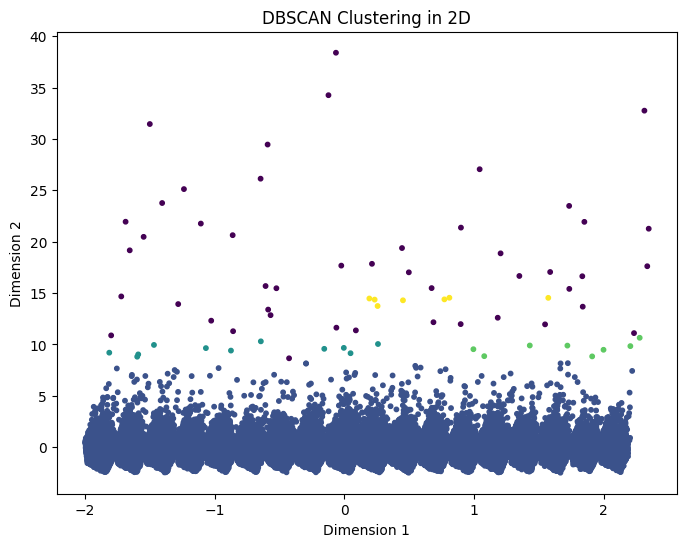

Noise proportion: 0.03310908386460498
Number of clusters: 4


In [6]:
data = transaction_sample[['user_id', 'dollar_value', 'merchant_abn', 'order_year', 'order_month', 'order_day']]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

pca = PCA(n_components=2)
data_2d = pca.fit_transform(scaled_data)

dbscan = DBSCAN(eps=0.86, min_samples=5)

labels = dbscan.fit_predict(data_2d)

plt.figure(figsize=(8, 6))
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis', s=10)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('DBSCAN Clustering in 2D')
plt.show()

# print the proportion of noise
print('Noise proportion:', 100 * list(labels).count(-1) / len(labels))

# print how many clusters
print('Number of clusters:', len(set(labels)) - (1 if -1 in labels else 0))

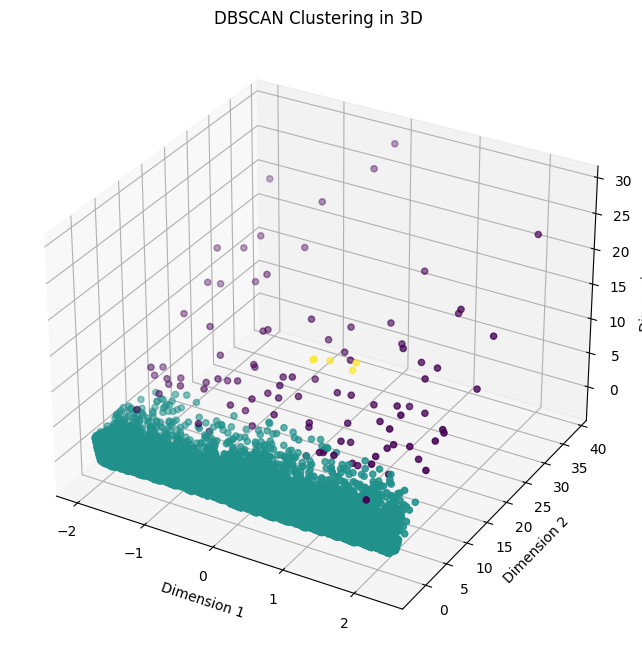

Noise proportion: 0.0690359621006657
Number of clusters: 2


In [14]:
data = transaction_sample[['user_id', 'dollar_value', 'merchant_abn', 'order_year', 'order_month', 'order_day']]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

pca = PCA(n_components=3)
data_3d = pca.fit_transform(scaled_data)

dbscan = DBSCAN(eps=0.86, min_samples=5)

labels = dbscan.fit_predict(data_3d)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# draw clusters
ax.scatter(data_3d[:, 0], data_3d[:, 1], data_3d[:, 2], c=labels, cmap='viridis')

# # show noise in black
# ax.scatter(data_3d[labels == -1, 0], data_3d[labels == -1, 1], data_3d[labels == -1, 2], c='black')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('DBSCAN Clustering in 3D')
plt.show()

# print the proportion of noise
print('Noise proportion:', 100 * list(labels).count(-1) / len(labels))

# print how many clusters
print('Number of clusters:', len(set(labels)) - (1 if -1 in labels else 0))



## Isolation Forest

### Merchant based Isolation Forest

In [76]:
whole_data = transaction.copy()

# date processing
whole_data['order_datetime'] = pd.to_datetime(whole_data['order_datetime'])
whole_data['order_year'] = whole_data['order_datetime'].dt.year
whole_data['order_month'] = whole_data['order_datetime'].dt.month
whole_data['order_day'] = whole_data['order_datetime'].dt.day

whole_data

,user_id,merchant_abn,dollar_value,order_id,order_datetime,order_year,order_month,order_day
0,1,28000487688,133.226894,0c37b3f7-c7f1-48cb-bcc7-0a58e76608ea,2021-02-28,2021,2,28
1,18485,62191208634,79.131400,9e18b913-0465-4fd4-92fd-66d15e65d93c,2021-02-28,2021,2,28
2,1,83690644458,30.441348,40a2ff69-ea34-4657-8429-df7ca957d6a1,2021-02-28,2021,2,28
3,18488,39649557865,962.813341,f4c1a5ae-5b76-40d0-ae0f-cb9730ac325a,2021-02-28,2021,2,28
4,2,80779820715,48.123977,cd09bdd6-f56d-489f-81ea-440f4bda933c,2021-02-28,2021,2,28
...,...,...,...,...,...,...,...,...
14195500,11136,77698107389,400.792069,5e68cb94-3eab-4342-83fa-65263eff26b8,2022-10-26,2022,10,26
14195501,11136,24852446429,5.384811,ba2ce936-ae49-4b70-a4b1-e8f8bacaefb3,2022-10-26,2022,10,26
14195502,11136,63685007785,48.129887,a6194c61-ae7a-4037-a425-2dd7cda42fb7,2022-10-26,2022,10,26
14195503,11137,85502310765,4.768752,72a3639e-25d5-4bcc-9e8b-26e737b8c0e4,2022-10-26,2022,10,26


as loop above in DBSCAN, also hold isolation forest within each merchant_abn: individually find the outliers and merge them together

In [69]:
def isolation_forest(data, contamination):
    """
    Perform anomaly detection using the Isolation Forest algorithm on a per-merchant basis.

    Args:
    - data (DataFrame): A pandas DataFrame containing the data, including 'merchant_abn', 'user_id', 'dollar_value', 'order_year', 'order_month', and 'order_day' columns.
    - contamination (float): The estimated proportion of anomalies in the dataset.

    Returns:
    - outliers (DataFrame): A pandas DataFrame containing the outliers, including 'merchant_abn', 'user_id', 'dollar_value', 'order_year', 'order_month', and 'order_day' columns.
    """
    outliers = pd.DataFrame(columns=['merchant_abn', 'user_id', 'dollar_value', 'order_year', 'order_month', 'order_day'])

    grouped = data.groupby('merchant_abn')
    for merchant, group_data in grouped:
        sales_data = group_data[['user_id', 'dollar_value', 'order_year', 'order_month', 'order_day']]

        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(sales_data)

        # comment this and try not to use pca (original result of 55k outliers with contamination='auto')
        # pca = PCA(n_components=1)
        # data = pca.fit_transform(scaled_data)
        
        isolation_forest = IsolationForest(contamination=contamination, random_state=42)
        cluster_labels = isolation_forest.fit_predict(scaled_data)
    
        outliers_indices = (cluster_labels == -1)

        outlier_data = sales_data[outliers_indices]
        outlier_data['merchant_abn'] = merchant
        outliers = pd.concat([outliers, outlier_data])

    return outliers

### treat as a whole

In [81]:
data_to_predict = whole_data[['user_id', 'merchant_abn', 'dollar_value', 'order_year', 'order_month', 'order_day']]
data_to_predict

,user_id,merchant_abn,dollar_value,order_year,order_month,order_day
0,1,28000487688,133.226894,2021,2,28
1,18485,62191208634,79.131400,2021,2,28
2,1,83690644458,30.441348,2021,2,28
3,18488,39649557865,962.813341,2021,2,28
4,2,80779820715,48.123977,2021,2,28
...,...,...,...,...,...,...
14195500,11136,77698107389,400.792069,2022,10,26
14195501,11136,24852446429,5.384811,2022,10,26
14195502,11136,63685007785,48.129887,2022,10,26
14195503,11137,85502310765,4.768752,2022,10,26


In [82]:
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
isolation_forest.fit(data_to_predict)

IsolationForest(contamination=0.1, random_state=42)

In [83]:
prediction = isolation_forest.predict(data_to_predict)
anomalies = data_to_predict[prediction == -1]
anomalies

,user_id,merchant_abn,dollar_value,order_year,order_month,order_day
0,1,28000487688,133.226894,2021,2,28
2,1,83690644458,30.441348,2021,2,28
3,18488,39649557865,962.813341,2021,2,28
4,2,80779820715,48.123977,2021,2,28
6,3,29566626791,46.330872,2021,2,28
...,...,...,...,...,...,...
14195448,11094,23092329041,1550.242948,2022,10,26
14195450,11098,31385641294,2252.022610,2022,10,26
14195455,11103,46654841462,1033.522845,2022,10,26
14195458,11106,14827550074,4770.010174,2022,10,26


In [85]:
# remove anomaly
mask2 = ~transaction[['user_id', 'merchant_abn', 'dollar_value']].isin(anomalies[['user_id', 'merchant_abn', 'dollar_value']]).any(axis=1)

transaction_normal2 = transaction[mask2].copy()
transaction_normal2 = transaction_normal2.reset_index(drop=True)

transaction_normal2

,user_id,merchant_abn,dollar_value,order_id,order_datetime
0,18485,62191208634,79.131400,9e18b913-0465-4fd4-92fd-66d15e65d93c,2021-02-28
1,18489,43186523025,98.148785,9008a98e-1b02-4de4-bc4c-47395f6275f6,2021-02-28
2,18491,64974914166,130.126019,4bc15338-83eb-43d8-97cd-fec507665445,2021-02-28
3,18493,43186523025,69.756456,6c494428-b293-4593-b609-47dfcad5cb66,2021-02-28
4,18493,67979471799,53.034325,dd61feff-5aa3-43d7-bf4b-2a3e32be01e1,2021-02-28
...,...,...,...,...,...
12775949,11136,77698107389,400.792069,5e68cb94-3eab-4342-83fa-65263eff26b8,2022-10-26
12775950,11136,24852446429,5.384811,ba2ce936-ae49-4b70-a4b1-e8f8bacaefb3,2022-10-26
12775951,11136,63685007785,48.129887,a6194c61-ae7a-4037-a425-2dd7cda42fb7,2022-10-26
12775952,11137,85502310765,4.768752,72a3639e-25d5-4bcc-9e8b-26e737b8c0e4,2022-10-26


In [86]:
# save the data
transaction_normal2.to_parquet('../data/curated/transaction/transaction_after_IF.parquet')

code for visulisation

In [ ]:
# selected_features = ['user_id', 'merchant_abn', 'dollar_value']

# pca = PCA(n_components=3)
# transaction_sample[['PC1', 'PC2', 'PC3']] = pca.fit_transform(transaction_sample[selected_features])

# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')

# # draw normal
# ax.scatter(transaction_sample['PC1'], transaction_sample['PC2'], transaction_sample['PC3'], c='green', label='Normal Data', alpha=0.3, s=1)

# # draw anomalies
# anomalies[['PC1', 'PC2', 'PC3']] = pca.transform(anomalies[selected_features])
# ax.scatter(anomalies['PC1'], anomalies['PC2'], anomalies['PC3'], c='red', label='Anomaly', alpha=0.6, s=1)

# ax.set_xlabel('Principal Component 1')
# ax.set_ylabel('Principal Component 2')
# ax.set_zlabel('Principal Component 3')
# ax.set_title('3D Scatter Plot of Data with Anomalies')
# plt.legend()
# plt.show()

## K-means (trial)

In [ ]:
features = ['dollar_value']

# Handling missing values, for simplicity, using dropna
transaction = transaction.dropna(subset=features)

# Scaling the feature(s)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(transaction[features])

In [ ]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
transaction['cluster'] = kmeans.fit_predict(X_scaled)

In [ ]:
# Calculating distance to the cluster center
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
transaction['center'] = transaction['cluster'].apply(lambda x: cluster_centers[x])
transaction['distance'] = abs(transaction['dollar_value'] - transaction['center'])


In [ ]:
threshold = float(transaction['distance'].quantile(0.9))
transaction['anomaly'] = transaction['distance'] > threshold

In [ ]:
print(transaction['anomaly'])
print(threshold) 

In [ ]:
transaction['anomaly'].value_counts()